In this notebook we will take a look at different pancreatic cancer cell lines and examine them with similar analysis methods as before.

# Part 0: Data Preparation

In [1]:
# importing data analysis libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def prepare_dataset(ds):
    table = pd.read_csv(ds, delimiter=',')
    table.drop('Unnamed: 0', axis=1, inplace=True)
    return table

coad_all = prepare_dataset('datasets/COAD_hgnc.csv')
lihc_all = prepare_dataset('datasets/LIHC_hgnc.csv')
prad_all = prepare_dataset('datasets/PRAD_hgnc.csv')

In [3]:
# might come back to deal with this warning? it gets the result for now
pd.options.mode.chained_assignment = None

# Part 1: Calculating TPM

Now that all of our csv files are imported, we can calculate TPM values for them. this function below is from the original cancer_expression_heatmap notebook file.

In [4]:
import pyensembl
ensembl = pyensembl.EnsemblRelease()

In [5]:
def calculate_rpk(sample_count, gene_length):
    reads_per_kilobase = sample_count / gene_length
    return reads_per_kilobase

def calculate_per_million(total_reads):
    return total_reads / 1000000

            
def find_gene_length_ensembl(gene_name):
    gene_search = ensembl.genes_by_name(gene_name)
    gene_length = (gene_search[0].end - gene_search[0].start) / 1000
    # clear the gene search cache
    gene_search = None
    return gene_length


def calculate_tpm(table, table_columns):
    
    missing_genes_dict = {'C12orf74':'PLEKHG7',
                     'LINC00856':'LINC00595'}

    precalculated_gene_length_dict = {'CCL3L1': 3.090}

    # converting this to numpy array so it's easier to work with
    # doing this loses the indexing that the original rnaseq table has but 
    # can be added back in later
    table_numpy = table.to_numpy(copy=True)
    
    
    ## -------- FOR CALCULATING RPK ----------
    rpk_table = table_numpy
    gene_length = 0

    for index, value in np.ndenumerate(table_numpy):
        if index[1] == 0:
            gene = value
            if gene in precalculated_gene_length_dict:
                gene_length = precalculated_gene_length_dict.get(value)
            else:
                if gene in missing_genes_dict:
                    gene = missing_genes_dict.get(value)
                gene_length = find_gene_length_ensembl(gene)

                
        else:
            rpk_table[index[0], index[1]] = calculate_rpk(value, gene_length)

    
    ## ---- FOR CALCULATING PER MILLION SCALING FACTOR -----
    per_mil_table = rpk_table
    
    total_reads = np.sum(rpk_table[:, 1:], axis=0)
    
    for index, value in np.ndenumerate(rpk_table):
        if (index[1] == 0):
            continue
        total_for_column = total_reads[index[1] - 1]
        
        scaling_factor = calculate_per_million(total_for_column)
        
        # this value references the rpk_table
        per_mil_table[index[0], index[1]] = value / scaling_factor
    
    tpm_table = pd.DataFrame(per_mil_table, columns=table_columns)
    
    return tpm_table

In [6]:
neurotransmitter_genes = pd.read_csv('datasets/neurotransmitter_gene_family.csv', delimiter = ',')

def filter_genes_of_interest(table):
    # take the RNASeq data table to only include genes of interest
    rnaseq_goi = table[table['hgnc_symbol'].isin(neurotransmitter_genes["receptor gene"])]
    return rnaseq_goi

def sort_genes_of_interest(table):
    
    receptor_gene_list = neurotransmitter_genes['receptor gene'].tolist()
    
    table.loc[:, 'hgnc_symbol'] = pd.Categorical(table['hgnc_symbol'], categories = receptor_gene_list, ordered = True)
    table = table.sort_values('hgnc_symbol')
    return table

In [7]:
def make_tpm(table):
    
    all_tpm = calculate_tpm(table, list(table.columns.values))
    tpm_goi = filter_genes_of_interest(all_tpm)
    tpm_sorted = sort_genes_of_interest(tpm_goi)
    
    return tpm_sorted

In [8]:
coad_tpm = make_tpm(coad_all)

In [9]:
lihc_tpm = make_tpm(lihc_all)

In [10]:
prad_tpm = make_tpm(prad_all)

# Part 2: Generating Heatmaps

Now we can generate heatmaps for each of the three cell lines. For each of the cell lines, we'll make a regular TPM heatmap, a zscore TPM heatmap, and a zscore log (TPM +!)

I'm importing the functions written in cancer_expression_heatmap.

In [60]:
def draw_expression_log_heatmap(table, y_axis_list, log_type, title, compute_zscore, sort, cmap, height, width):
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = table.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    rnaseq_columns = list(table.columns.values)
    
    expression_grid = expression_grid + 1
    # print (expression_grid)

    if log_type == 'natural':
        expression_logged = np.log(expression_grid)
    elif log_type == 'base-10':
        expression_logged = np.log10(expression_grid)
    else:
        expression_logged = expression_grid
    

    # print(expression_logged)
    if compute_zscore:
        expression_logged = z_score(expression_logged)
    
    if sort:
        expression_logged_pandas = convert_numpy_to_pandas(expression_logged, rnaseq_columns[1:])
        expression_logged_pandas_sorted = sort_table(expression_logged_pandas)
        y_axis_list = expression_logged_pandas_sorted['hgnc_symbol'].tolist()
        expression_logged = convert_pandas_to_numpy(expression_logged_pandas_sorted)
        
    
    fig, ax = plt.subplots()
    
    
    # it's cmap='Blues_r' to change the color scheme
    im = ax.imshow(expression_logged, cmap=cmap)
    
    # show labels for y axis
    ax.set_yticks(np.arange(len(y_axis_list)))
    ax.set_yticklabels(y_axis_list, fontsize=10)
    
    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(height, width)
    
    
    fig.colorbar(im, fraction = 0.025, pad = 0.03)
    
    ax.set_title(title, fontsize=40, ha='center')
    fig.tight_layout()
    plt.show()
    
    fig.savefig('image/test.png', dpi=100)
    

In [43]:
from scipy import stats

In [53]:
def z_score(numpy_table):
    stats.zscore(numpy_table)
    return numpy_table

receptor_gene_list = neurotransmitter_genes['receptor gene'].tolist()

def convert_numpy_to_pandas(numpy_table, table_columns):
    pandas_table = pd.DataFrame(numpy_table, columns=table_columns)
    pandas_table.insert(0, 'hgnc_symbol', receptor_gene_list)
    return pandas_table

def convert_pandas_to_numpy(pandas_table):
    as_numpy = pandas_table.drop('hgnc_symbol', axis=1)
    return as_numpy.to_numpy(dtype=float)

def sort_table(table):
    # creating a new table for sorting purposes
    rnaseq_orig = table.copy()
    
    # converting the neurotransmitter dataframe table into a python dict
    neuro_genes_dict = {}
    for index, row in neurotransmitter_genes.iterrows():
        value = row[0]
        if (value in neuro_genes_dict):
            gene_list = neuro_genes_dict[value]
        else:
            gene_list = []
        gene_list.append(row[1])
        neuro_genes_dict[value] = gene_list
    
    # sort table wasn't working right with decimals, so hgnc symbol column was removed
    excluded = rnaseq_orig.loc[:, 'hgnc_symbol']
    rnaseq_orig.drop('hgnc_symbol', axis=1, inplace=True)
    rnaseq_orig.loc[:, 'Total by row'] = rnaseq_orig.sum(axis=1)
    rnaseq_with_total = pd.concat([excluded.rename('hgnc_symbol'), rnaseq_orig], axis=1)
    
    table_columns = list(table.columns.values)
    
    # SORTING THE ROWS -------
    rnaseq_sorted = pd.DataFrame(columns=table_columns)
    
    # sorts the rows section by section, based on the size of each family of neurotransmitters
    index_begin = 0
    index_end = 0
    appended_data = []
    for family, gene_list in neuro_genes_dict.items():
        index_end = len(gene_list) + index_begin
        to_sort = rnaseq_with_total[index_begin : index_end].sort_values('Total by row', ascending=True)
        appended_data.append(to_sort)
        index_begin = index_end
    # the families were sorted as separate dataframes and then concat together
    rnaseq_sorted = pd.concat(appended_data)
    
    
    # adding the column sum back in so now we can sort by column
    rnaseq_sorted_2 = rnaseq_sorted.to_numpy(copy=True)
    rnaseq_sorted = pd.DataFrame(rnaseq_sorted_2)
    
    table_columns.append('Total by row')
    rnaseq_sorted.columns = table_columns
    rnaseq_sorted.loc['Total by col', :] = rnaseq_with_total.sum(axis=0)
    table_columns.remove('Total by row')
    
    # SORTING THE COLUMNS ----------
    
    # remove hgnc_symbol column, sort the values, and then remove the total col and total row   
    excluded_after_row_sorting = rnaseq_sorted.loc[:, 'hgnc_symbol']
    del rnaseq_sorted['hgnc_symbol']
    sorted_cases = rnaseq_sorted.sort_values('Total by col', axis=1, ascending=True)
    rnaseq_sorted = pd.concat([excluded_after_row_sorting.rename('hgnc_symbol'), sorted_cases], axis=1)
    rnaseq_sorted.drop('Total by col', axis=0, inplace=True)
    rnaseq_sorted.drop('Total by row', axis=1, inplace=True)
    return rnaseq_sorted

In [37]:
def draw_expression_heatmap(table, y_axis_list, cmap, title, height, width):
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = table.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    fig, ax = plt.subplots()
    # it's cmap='Blues_r' to change the color scheme
    im = ax.imshow(expression_grid, cmap=cmap)
    
    # show labels for y axis
    ax.set_yticks(np.arange(len(y_axis_list)))
    ax.set_yticklabels(y_axis_list, fontsize=10)
    
    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(height, width)
    
    
    fig.colorbar(im, fraction = 0.02, pad = 0.03)
    
    ax.set_title(title, fontsize=40, ha='center')
    fig.tight_layout()
    plt.show()
    
    fig.savefig('image/expression_heatmap.png', dpi=100)

## Part 1.a -- COAD Line

TPM Heatmap:

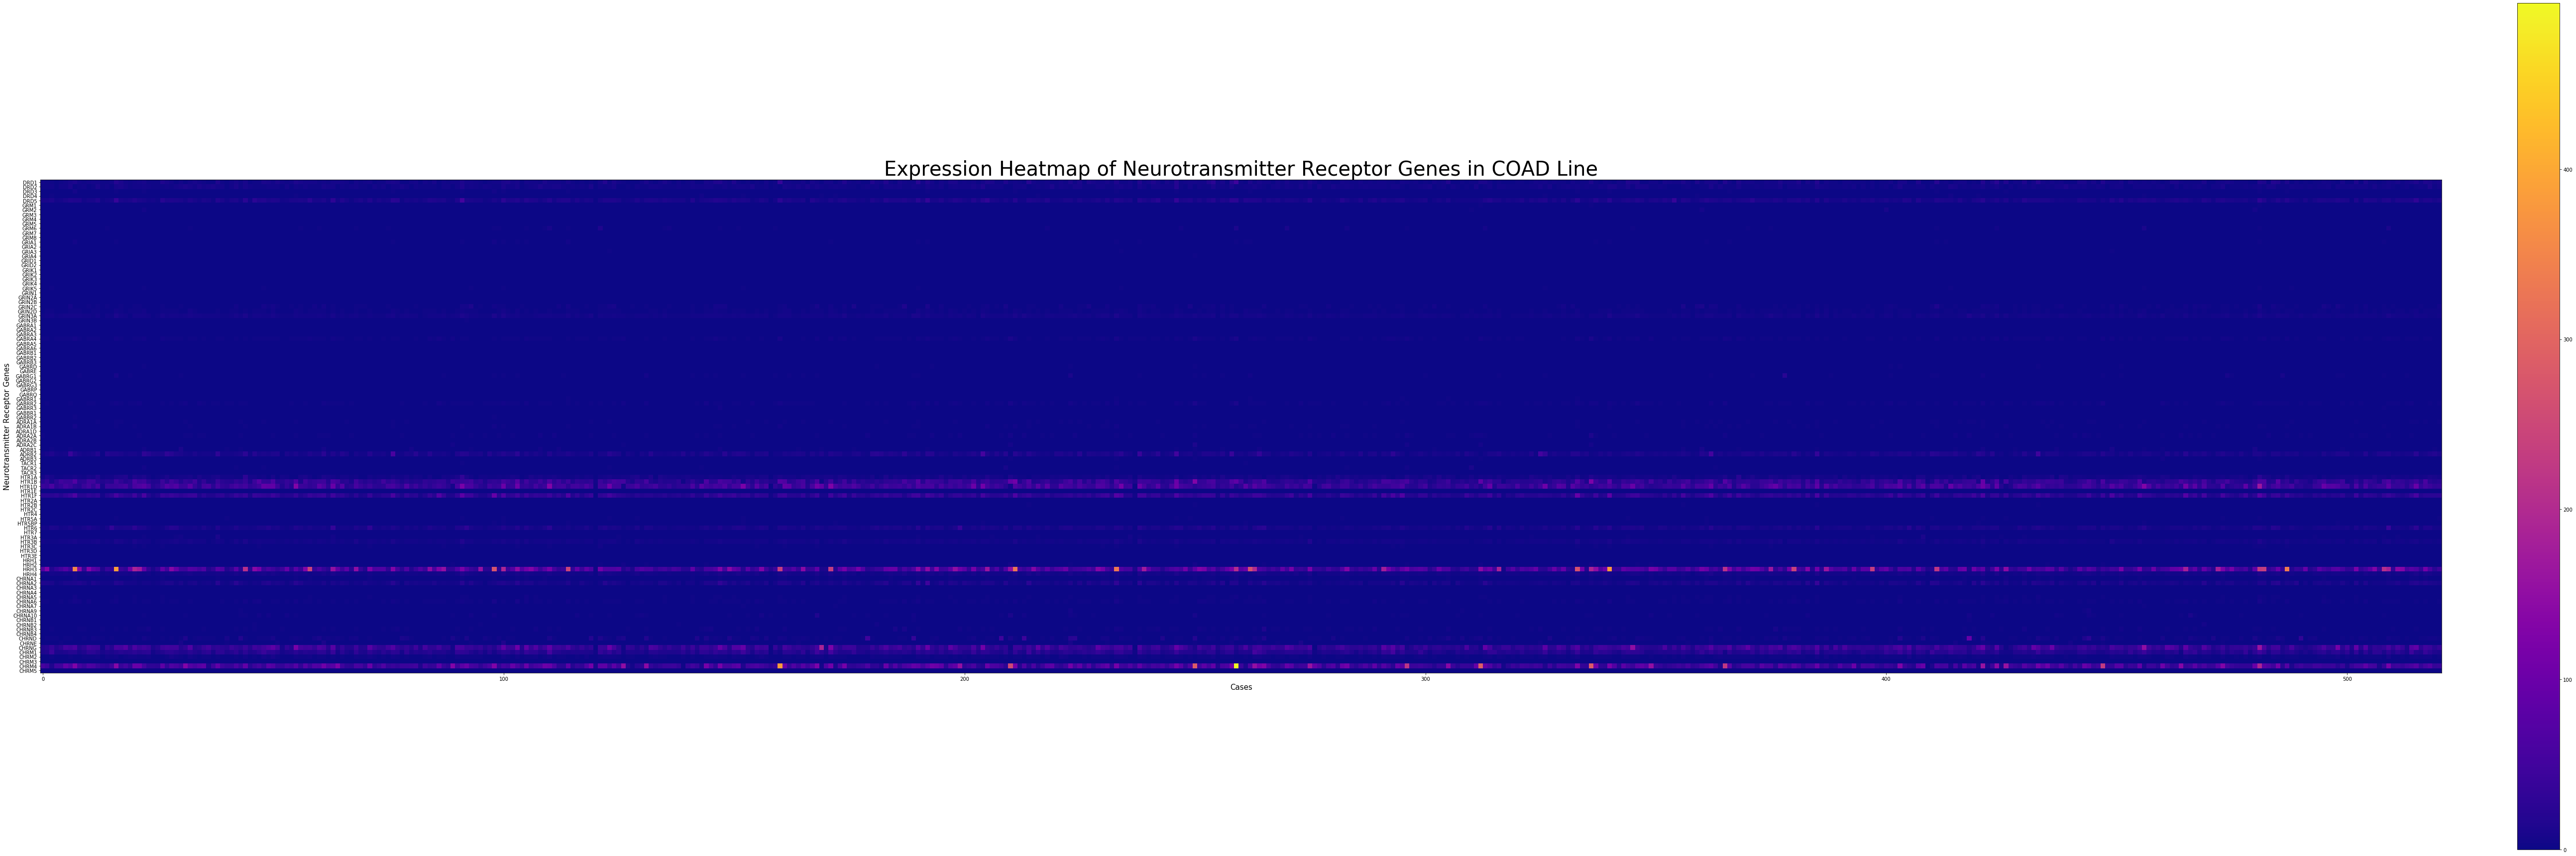

In [40]:
draw_expression_heatmap(coad_tpm, coad_tpm['hgnc_symbol'].tolist(), 'plasma', 'Expression Heatmap of Neurotransmitter Receptor Genes in COAD Line', 72, 24)

Z-Score TPM Heatmap:

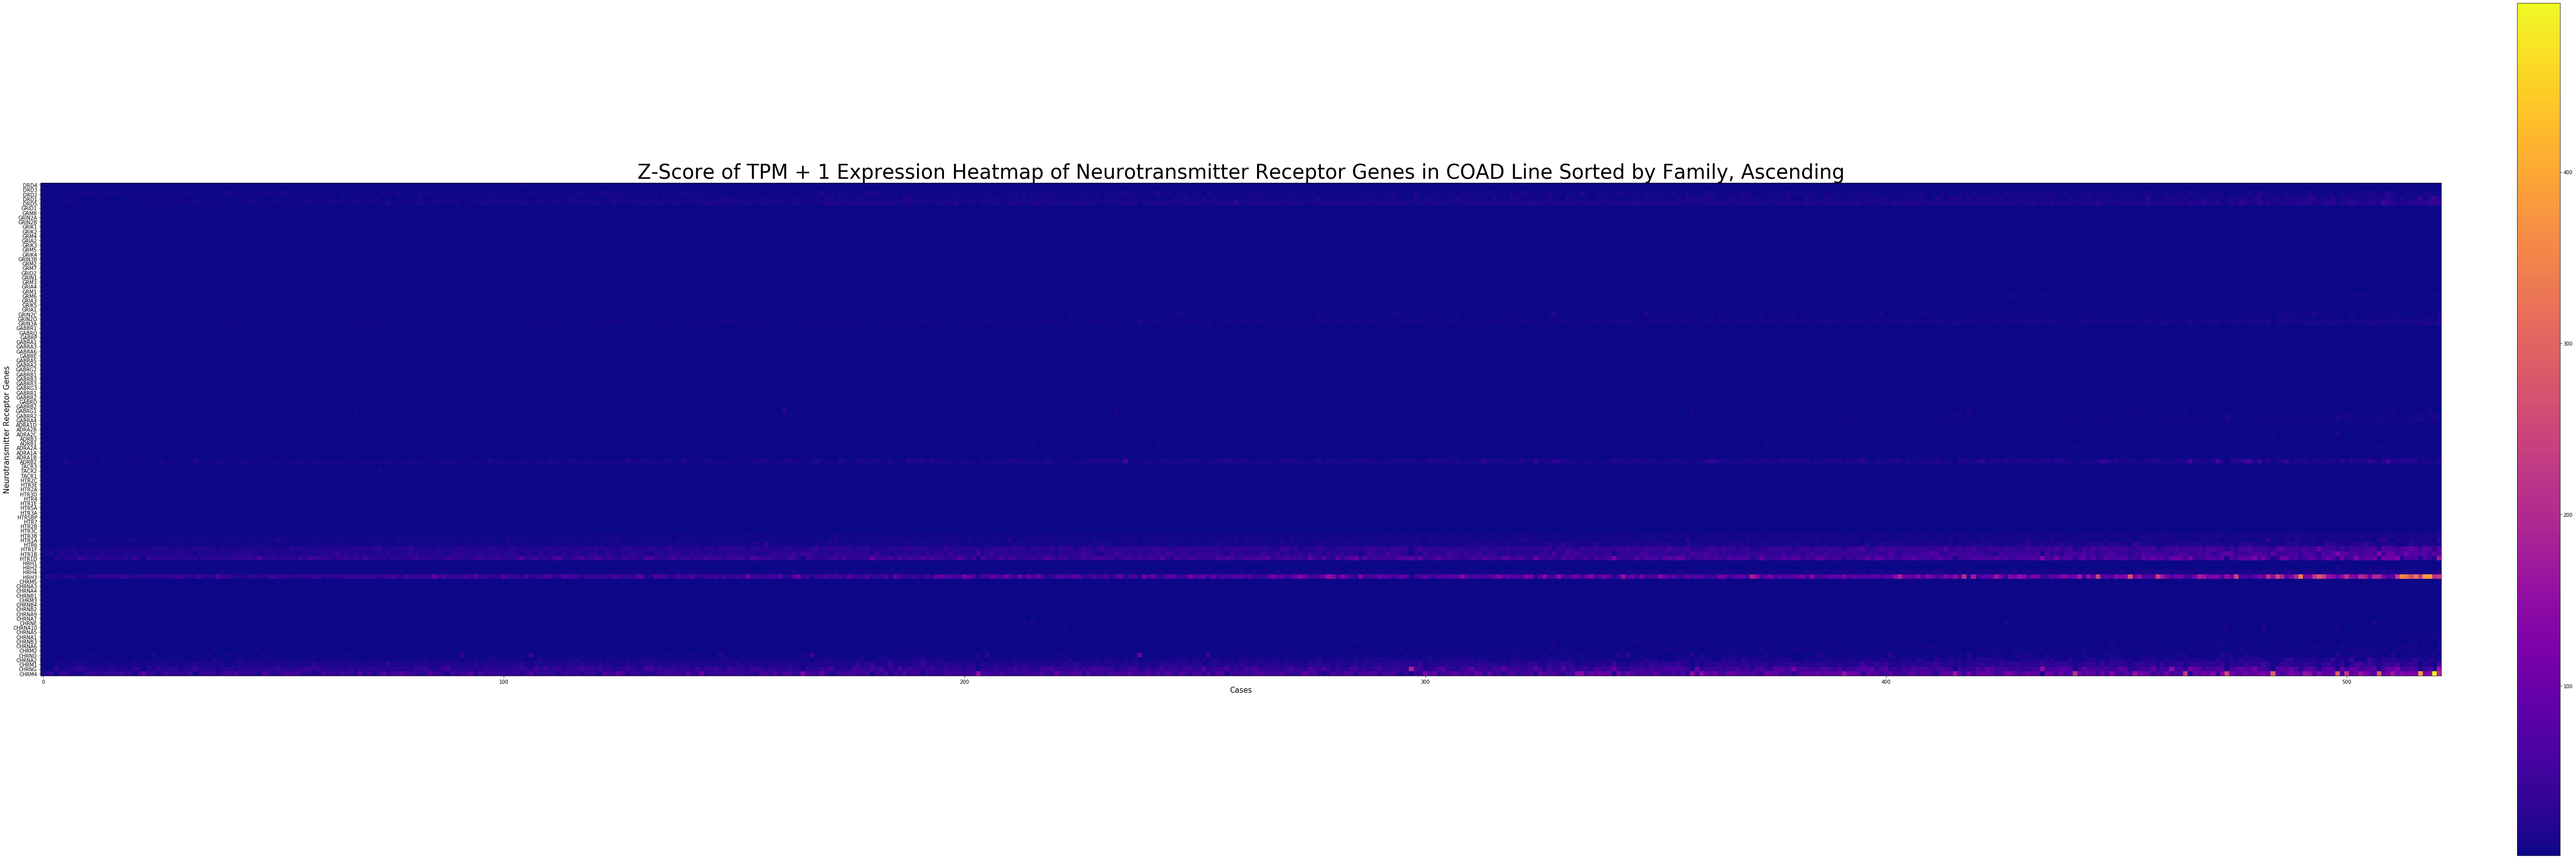

In [61]:
draw_expression_log_heatmap(coad_tpm, coad_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM + 1 Expression Heatmap of Neurotransmitter Receptor Genes in COAD Line Sorted by Family, Ascending', True, True, 'plasma', 72, 24)

Z-Score of Ln (TPM + 1) Heatmap:

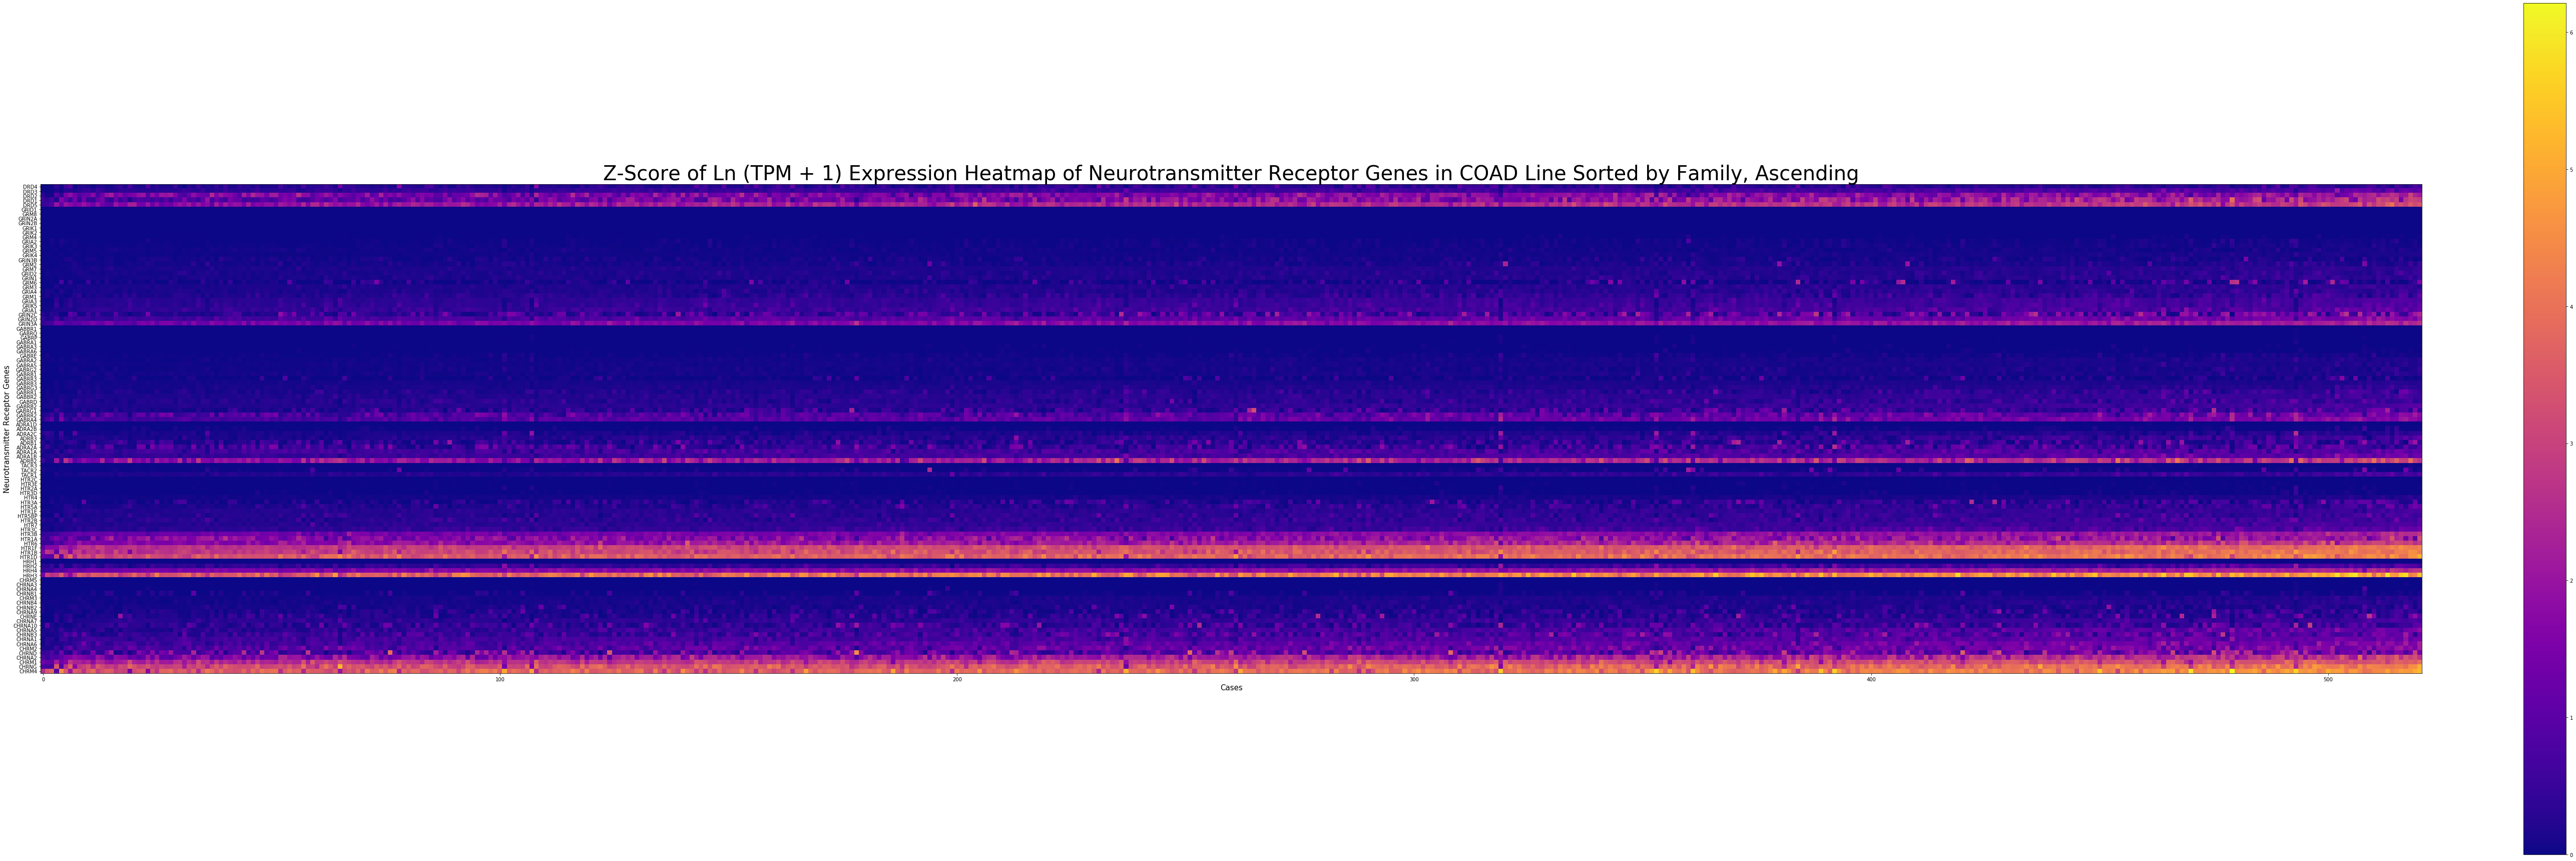

In [59]:
draw_expression_log_heatmap(coad_tpm, coad_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln (TPM + 1) Expression Heatmap of Neurotransmitter Receptor Genes in COAD Line Sorted by Family, Ascending', True, True, 'plasma', 72, 24)

## Part 1.b -- LIHC Line

TPM Heatmap:

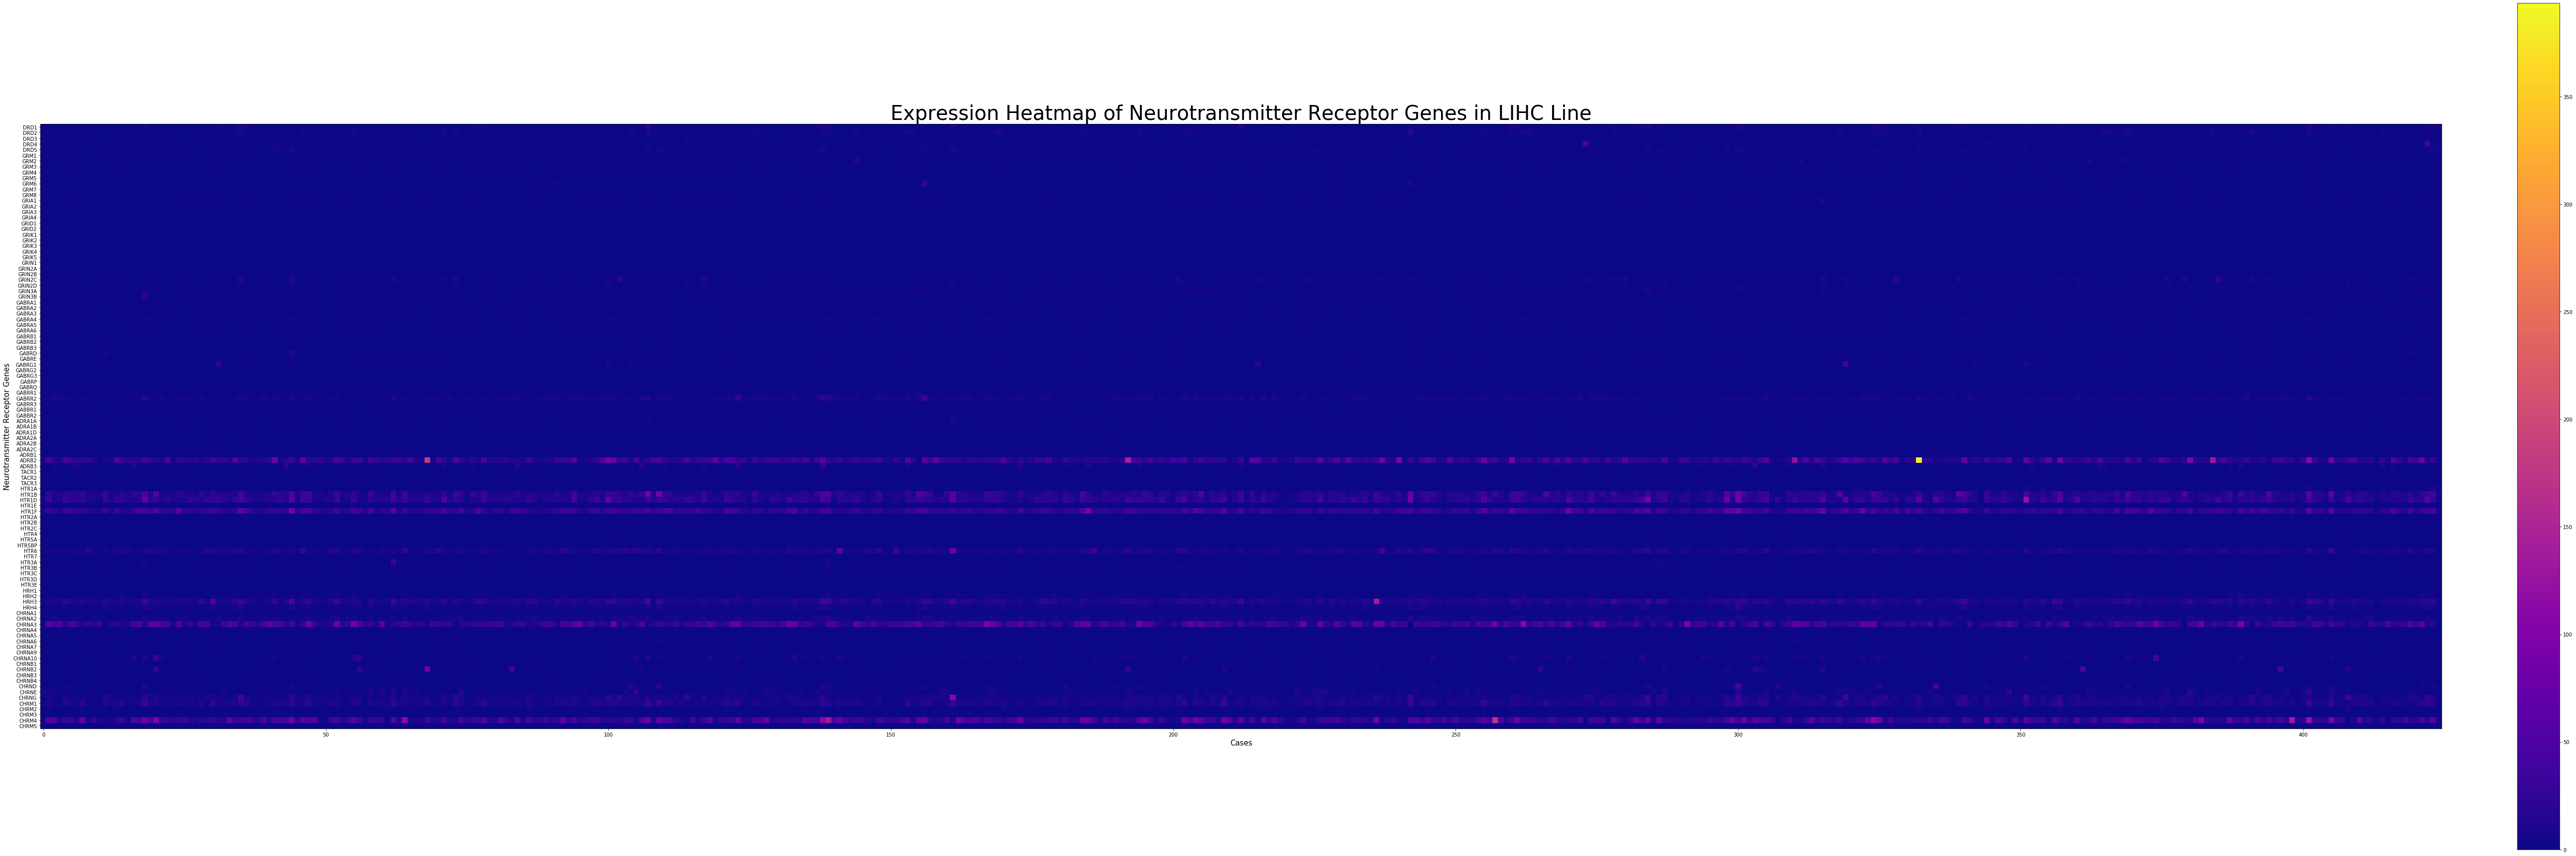

In [62]:
draw_expression_heatmap(lihc_tpm, lihc_tpm['hgnc_symbol'].tolist(), 'plasma', 'Expression Heatmap of Neurotransmitter Receptor Genes in LIHC Line', 72, 24)

Z-Score TPM Heatmap:

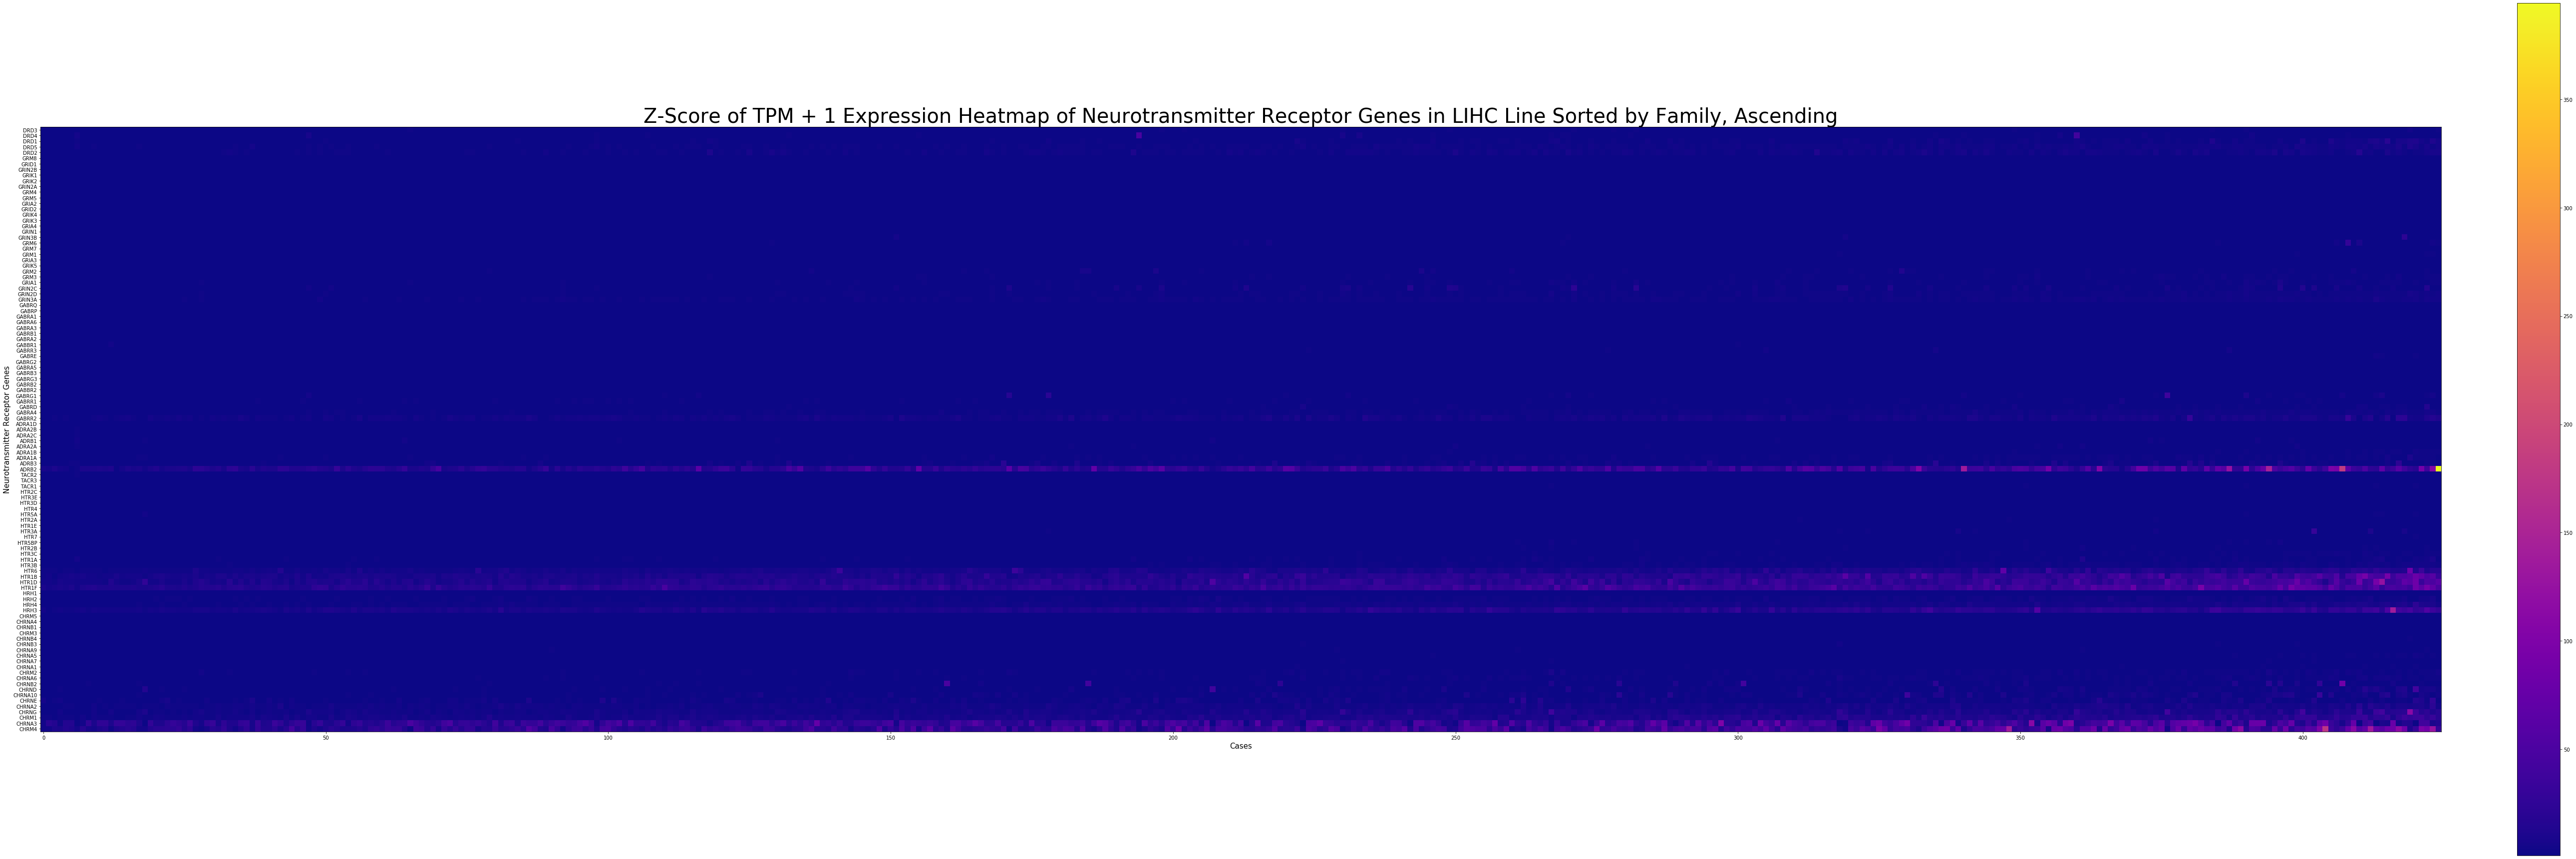

In [63]:
draw_expression_log_heatmap(lihc_tpm, lihc_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM + 1 Expression Heatmap of Neurotransmitter Receptor Genes in LIHC Line Sorted by Family, Ascending', True, True, 'plasma', 72, 24)

Z-Score of Ln (TPM + 1) Heatmap:

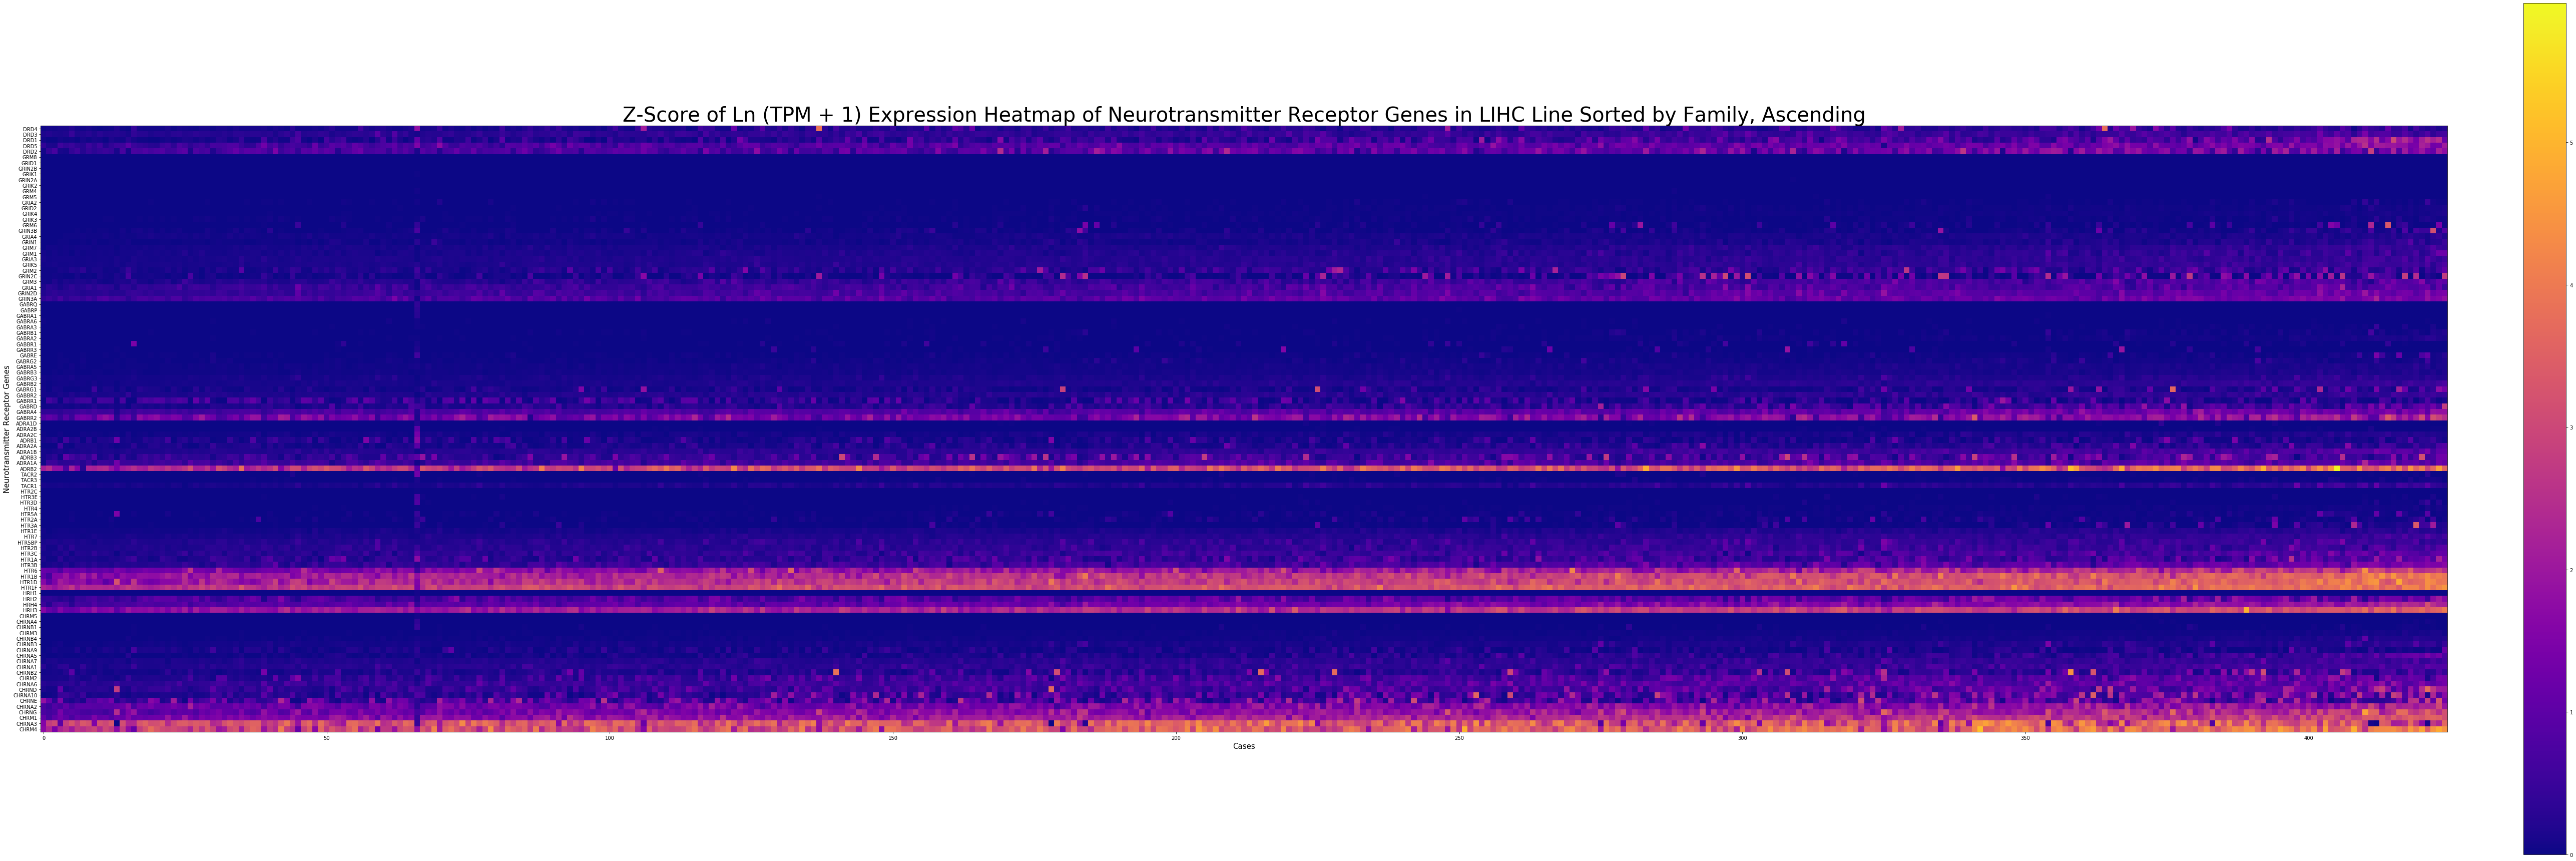

In [64]:
draw_expression_log_heatmap(lihc_tpm, lihc_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln (TPM + 1) Expression Heatmap of Neurotransmitter Receptor Genes in LIHC Line Sorted by Family, Ascending', True, True, 'plasma', 72, 24)

## Part 1.c -- PRAD Line

TPM Heatmap:

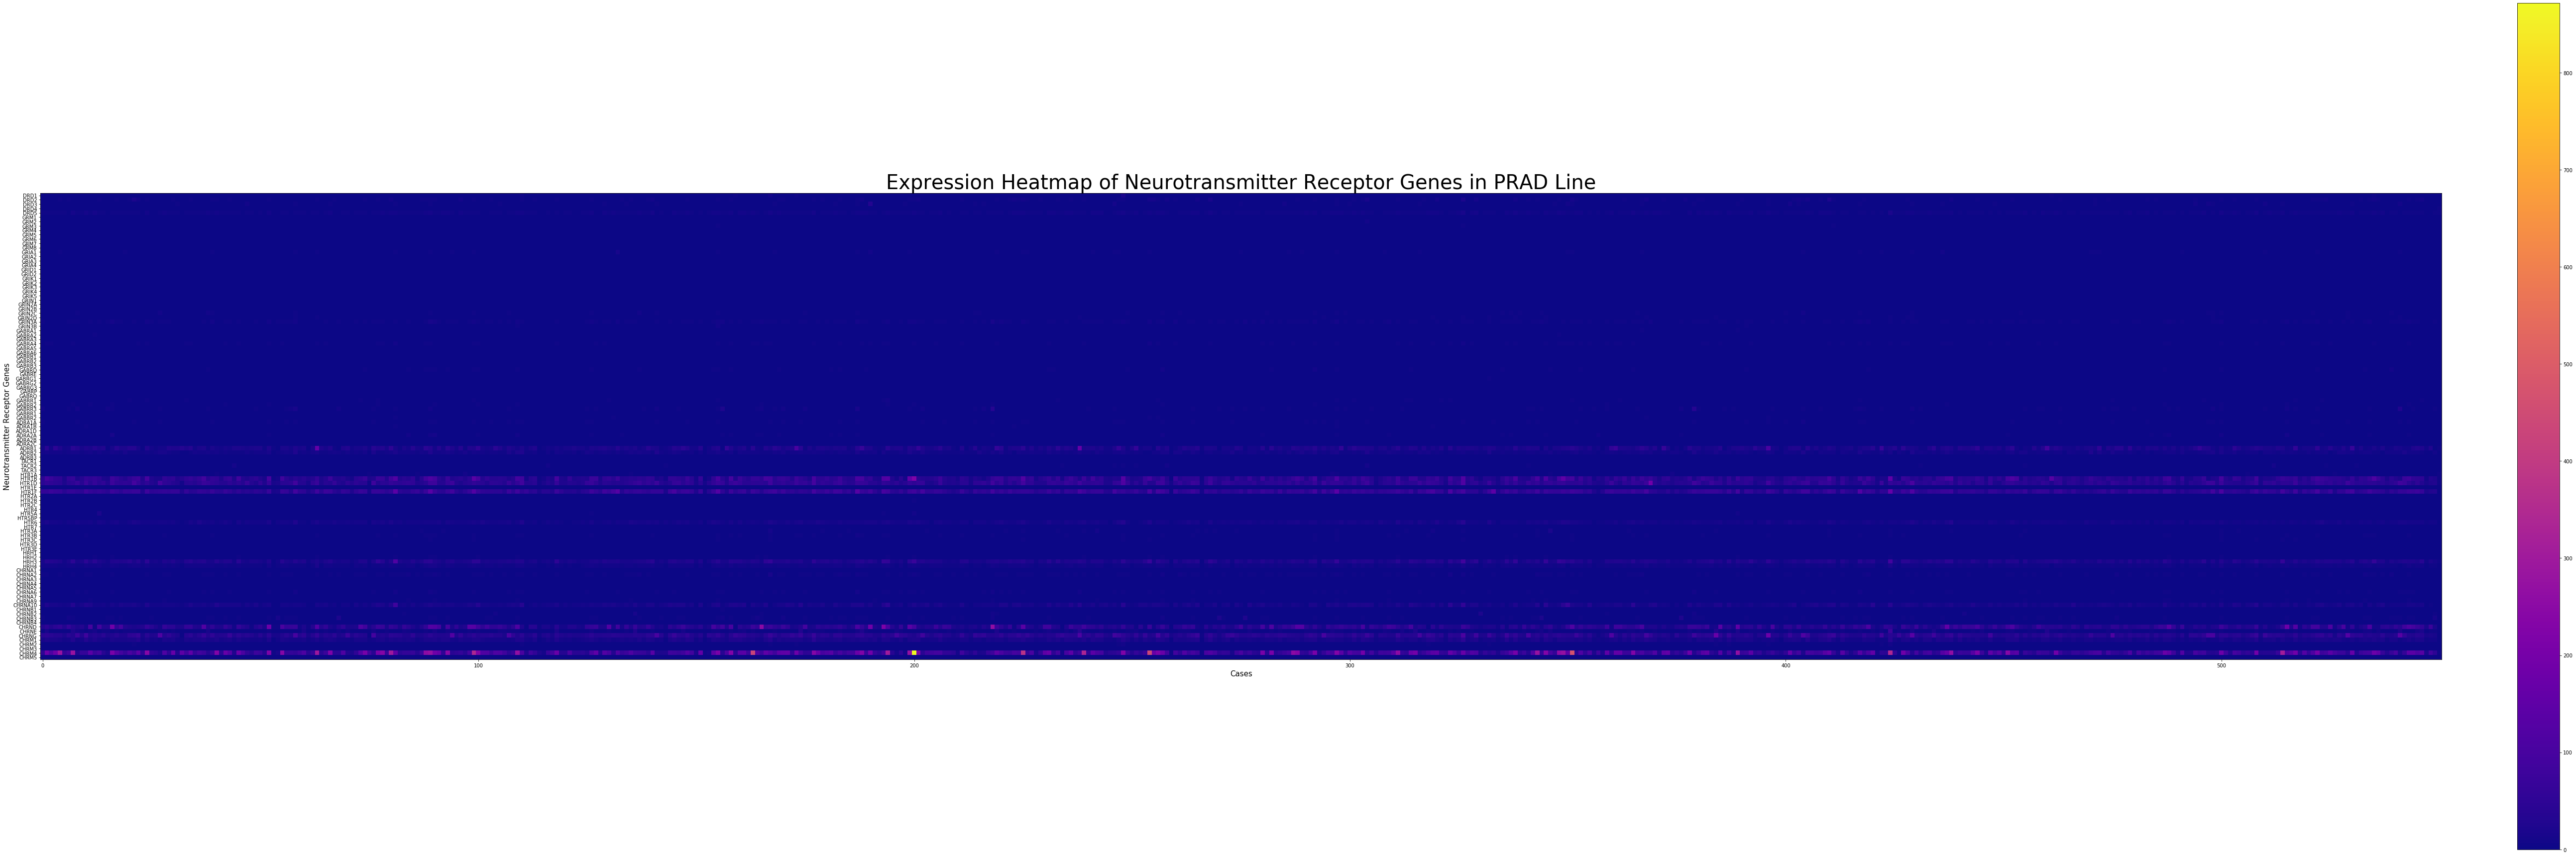

In [65]:
draw_expression_heatmap(prad_tpm, prad_tpm['hgnc_symbol'].tolist(), 'plasma', 'Expression Heatmap of Neurotransmitter Receptor Genes in PRAD Line', 72, 24)

Z-Score TPM Heatmap:

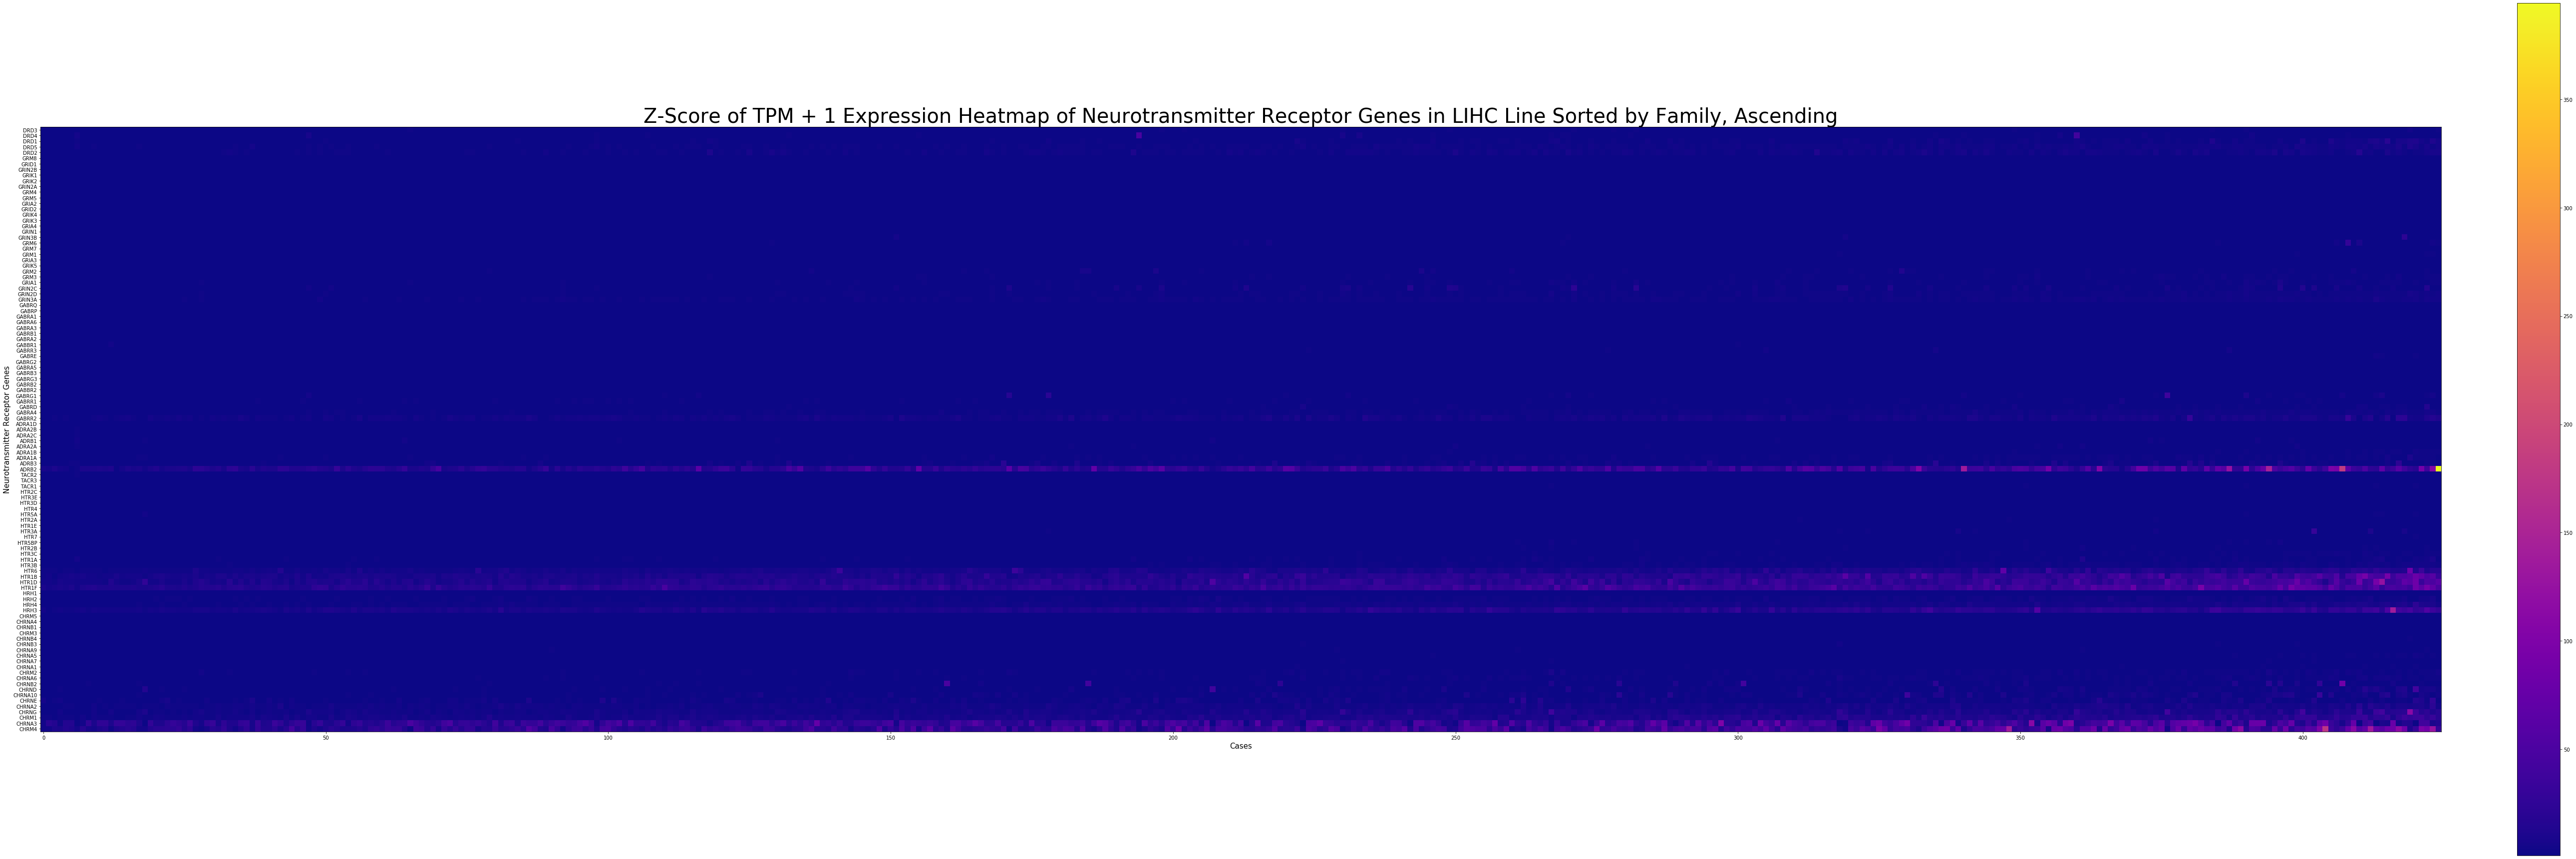

In [63]:
draw_expression_log_heatmap(prad_tpm, prad_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM + 1 Expression Heatmap of Neurotransmitter Receptor Genes in PRAD Line Sorted by Family, Ascending', True, True, 'plasma', 72, 24)

Z-Score of Ln (TPM + 1) Heatmap:

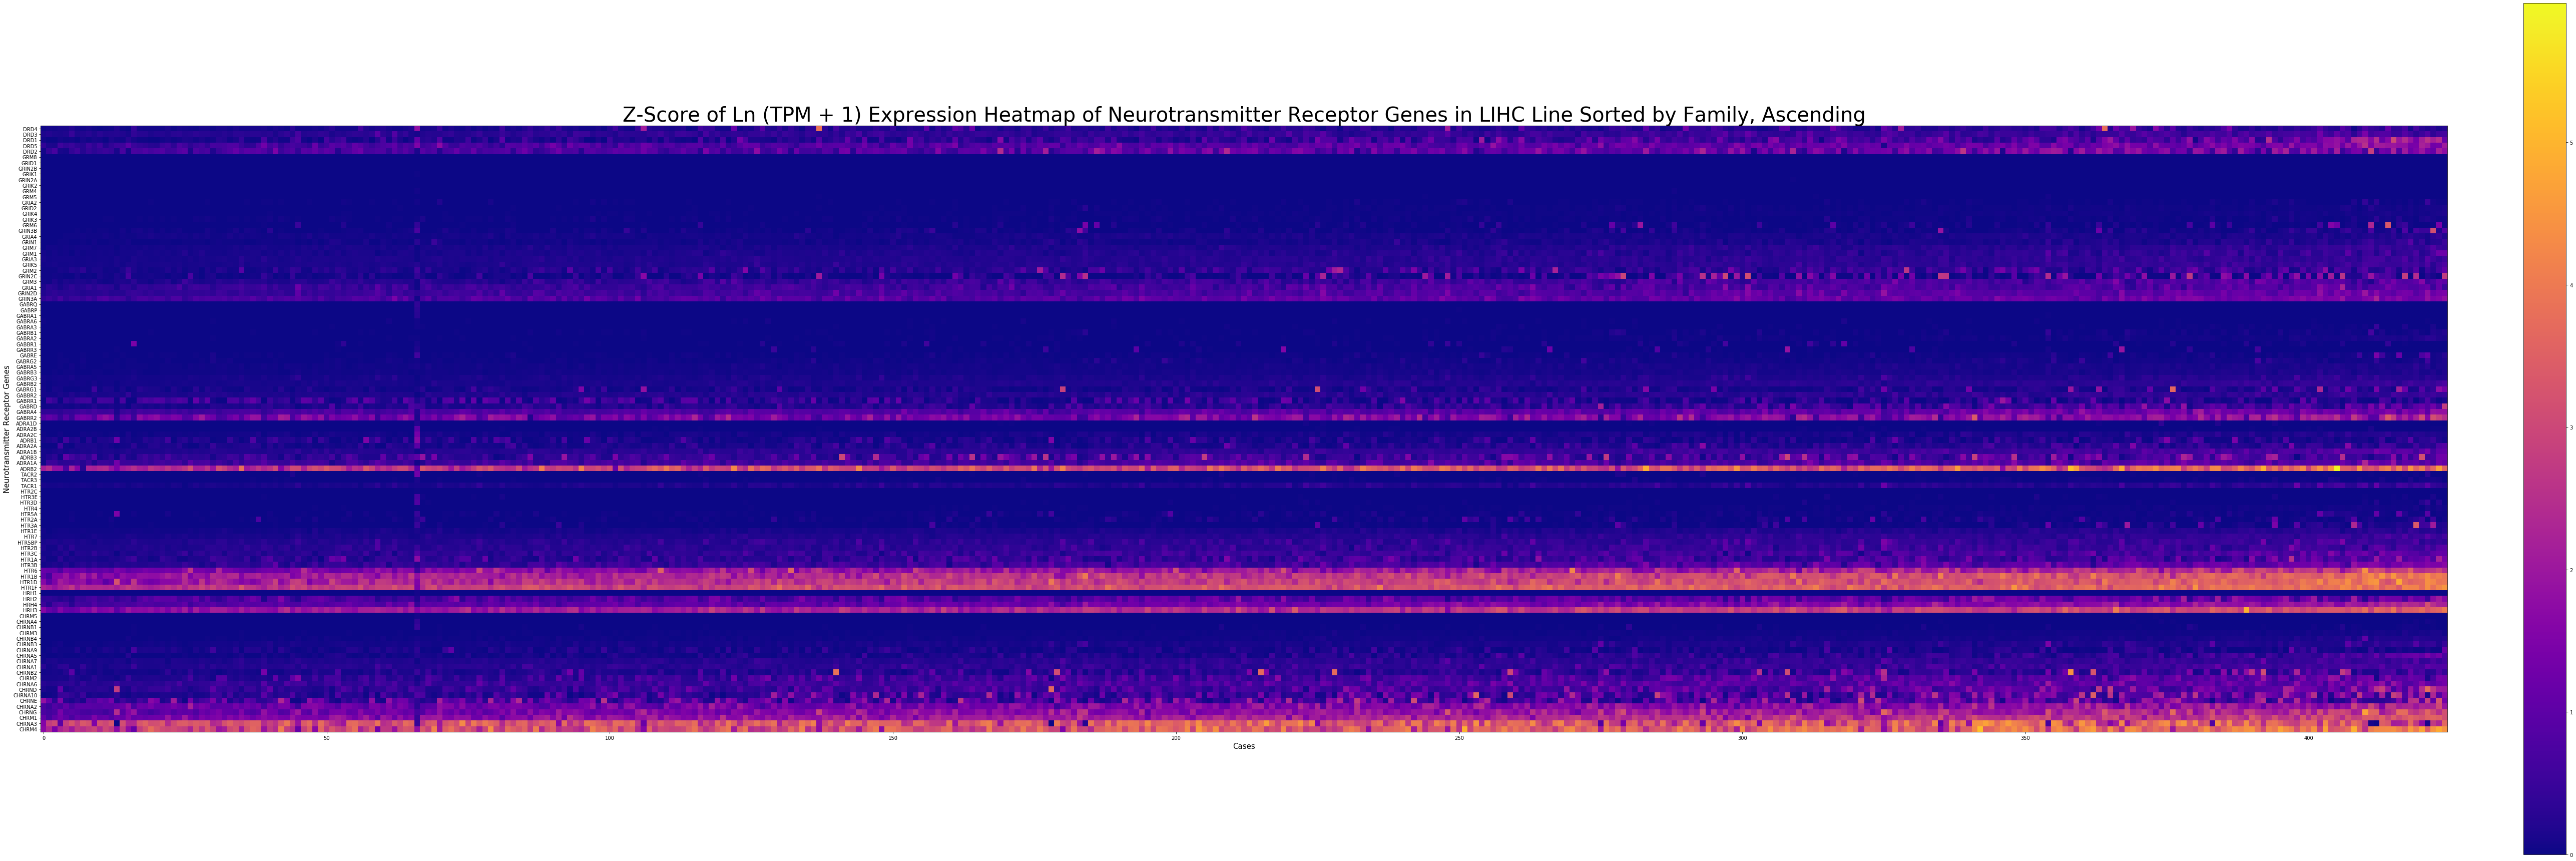

In [64]:
draw_expression_log_heatmap(prad_tpm, prad_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln (TPM + 1) Expression Heatmap of Neurotransmitter Receptor Genes in PRAD Line Sorted by Family, Ascending', True, True, 'plasma', 72, 24)